In [1]:
cd /fs-computility/mllm1/limo/workspace/stepfun/Open-Reasoner-Zero

/fs-computility/mllm1/limo/workspace/stepfun/Open-Reasoner-Zero


In [3]:
import json

# 读取 JSONL 文件
with open('orz_ckpt/debug_orz_7b_ppo_needlebench/dumped_replay_buffer/iter0_replay_buffer.jsonl', 'r') as f:
    # 读取第一行来查看结构
    first_line = f.readline()
    data = json.loads(first_line)
    
    # 打印结构，每个属性最多显示5行
    print("JSON 结构：")
    
    def truncate_json(obj, max_items=5):
        if isinstance(obj, dict):
            return {k: truncate_json(v, max_items) for k, v in list(obj.items())[:max_items]}
        elif isinstance(obj, list):
            if len(obj) > max_items:
                return obj[:max_items] + ["...省略剩余项..."]
            return [truncate_json(item, max_items) for item in obj]
        else:
            return obj
    
    truncated_data = truncate_json(data)
    print(json.dumps(truncated_data, indent=2, ensure_ascii=False))

JSON 结构：
{
  "sequences": [
    32,
    10435,
    1948,
    2657,
    323,
    "...省略剩余项..."
  ],
  "action_log_probs": [
    -0.00072479248046875,
    -4.09375,
    -0.37109375,
    -4.59375,
    -1.640625,
    "...省略剩余项..."
  ],
  "base_action_log_probs": [
    -0.00072479248046875,
    -4.09375,
    -0.37109375,
    -4.59375,
    -1.640625,
    "...省略剩余项..."
  ],
  "values": [
    0.08740234375,
    0.041015625,
    0.0419921875,
    -0.042724609375,
    0.01416015625,
    "...省略剩余项..."
  ],
  "returns": [
    0.0,
    0.0,
    0.0,
    0.0,
    0.0,
    "...省略剩余项..."
  ]
}


In [10]:
# 方案：使用字体回退机制，同时支持中英文
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 设置字体顺序：先尝试一个英文字体，再回退到中文字体
plt.rcParams['font.family'] = ['DejaVu Sans', 'Droid Sans Fallback']

# 确保负号正确显示
plt.rcParams['axes.unicode_minus'] = False

In [13]:
# 进一步分析回放缓冲区内容
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

# 加载与训练时相同的tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-7B", trust_remote_code=True)


共加载了 4 条经验数据

第一条数据解码后的文本内容:
A conversation between User and Assistant. The User asks a question, and the Assistant solves it. The Assistant first thinks about the reasoning process in the mind and then provides the User with the answer. The reasoning process is enclosed within <think> </think> and answer is enclosed within <answer> </answer> tags, respectively, i.e., <think> reasoning process here </think> <answer> answer here </answer>. User: You must put your answer inside <answer> </answer> tags, i.e., <answer> answer here </answer>. And your final answer will be extracted automatically by the \boxed{} tag.
This is the problem:
Here is a test for multi-step reasoning ability called the Ancestral Trace Challenge. In this test, we will simulate different people's familial relationships, and your task is to continuously reason through them until you identify the eldest ancestor.

Now, the scrambled family relationships are provided below:
Cathy Graham is Sharon House's mother.For Tiff

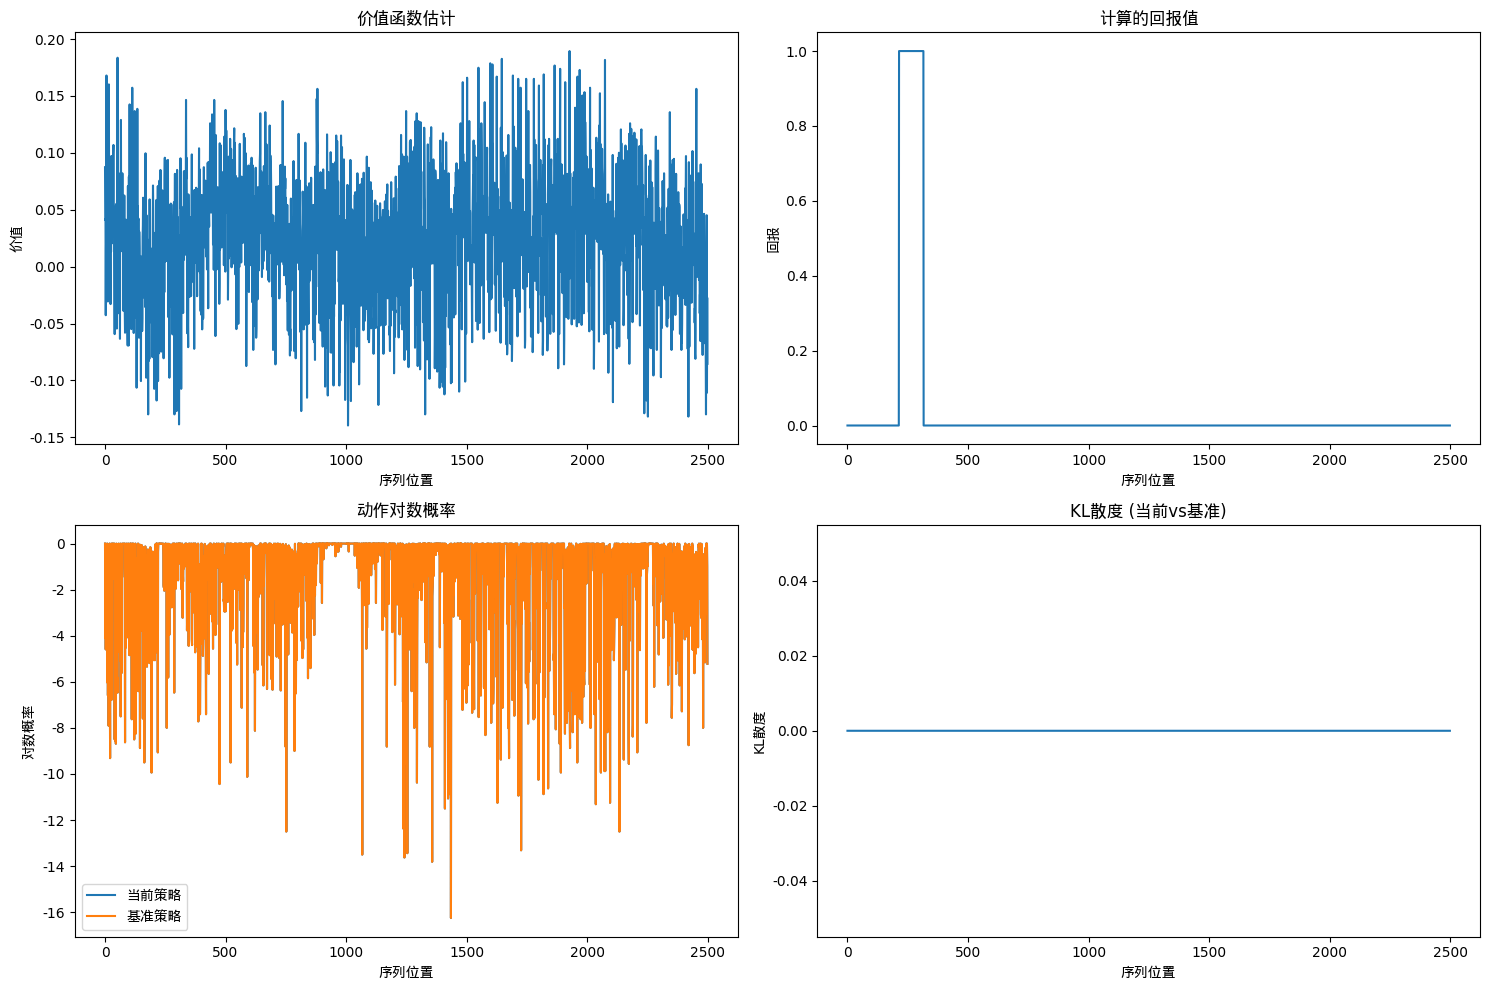


多条经验的统计分析:
平均序列长度: 14527.75
平均价值估计: 0.0247


In [12]:
# 读取完整的JSONL文件并分析
experiences = []
with open('orz_ckpt/debug_orz_7b_ppo_needlebench/dumped_replay_buffer/iter0_replay_buffer.jsonl', 'r') as f:
    for line in f:
        experiences.append(json.loads(line))

print(f"共加载了 {len(experiences)} 条经验数据")

# 分析第一条经验的详细内容
example = experiences[0]

# 1. 解码token序列为实际文本
token_ids = example['sequences']
decoded_text = tokenizer.decode(token_ids)
print("\n第一条数据解码后的文本内容:")
print(decoded_text)

# 2. 分析奖励和价值估计
if 'rewards' in example:
    rewards = example['rewards']
    print(f"\n奖励统计: 平均值={np.mean(rewards):.4f}, 最大值={max(rewards):.4f}, 最小值={min(rewards):.4f}")

values = example['values']
returns = example['returns']
print(f"\n价值函数统计: 平均值={np.mean(values):.4f}, 最大值={max(values):.4f}, 最小值={min(values):.4f}")
print(f"回报统计: 平均值={np.mean(returns):.4f}, 最大值={max(returns):.4f}, 最小值={min(returns):.4f}")

# 3. 分析策略变化
action_log_probs = example['action_log_probs']
base_action_log_probs = example['base_action_log_probs']
kl_div = np.array(action_log_probs) - np.array(base_action_log_probs)
print(f"\nKL散度统计: 平均值={np.mean(kl_div):.4f}, 最大值={max(kl_div):.4f}, 最小值={min(kl_div):.4f}")

# 4. 可视化一些关键指标
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(values)
plt.title('价值函数估计')
plt.xlabel('序列位置')
plt.ylabel('价值')

plt.subplot(2, 2, 2)
plt.plot(returns)
plt.title('计算的回报值')
plt.xlabel('序列位置')
plt.ylabel('回报')

plt.subplot(2, 2, 3)
plt.plot(action_log_probs)
plt.plot(base_action_log_probs)
plt.title('动作对数概率')
plt.xlabel('序列位置')
plt.ylabel('对数概率')
plt.legend(['当前策略', '基准策略'])

plt.subplot(2, 2, 4)
plt.plot(kl_div)
plt.title('KL散度 (当前vs基准)')
plt.xlabel('序列位置')
plt.ylabel('KL散度')

plt.tight_layout()
plt.show()

# 5. 如果有多条经验，分析它们的一些统计特征
if len(experiences) > 1:
    print("\n多条经验的统计分析:")
    avg_sequence_length = np.mean([len(exp['sequences']) for exp in experiences])
    print(f"平均序列长度: {avg_sequence_length:.2f}")
    
    if 'rewards' in experiences[0]:
        avg_rewards = [np.mean(exp['rewards']) for exp in experiences]
        print(f"平均奖励: {np.mean(avg_rewards):.4f}")
    
    avg_values = [np.mean(exp['values']) for exp in experiences]
    print(f"平均价值估计: {np.mean(avg_values):.4f}")